<a href="https://colab.research.google.com/github/abhinavtembulkar/movie-review-sentiment-prediction/blob/master/Movie_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MOVIE REVIEWS
- 0 -> Negative review
- 1 -> Positive review

mkdir: cannot create directory ‘Dataset’: File exists
--2020-07-13 14:33:30--  http://conceptnet.s3.amazonaws.com/precomputed-data/2016/numberbatch/17.06/mini.h5
Resolving conceptnet.s3.amazonaws.com (conceptnet.s3.amazonaws.com)... 52.216.234.43
Connecting to conceptnet.s3.amazonaws.com (conceptnet.s3.amazonaws.com)|52.216.234.43|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133916723 (128M) [application/x-hdf]
Saving to: ‘./Dataset/mini.h5.1’

mini.h5.1           100%[===================>] 127.71M  50.0MB/s    in 2.6s    

2020-07-13 14:33:33 (50.0 MB/s) - ‘./Dataset/mini.h5.1’ saved [133916723/133916723]

--2020-07-13 14:33:34--  https://github.com/duke-mlss/Duke-MLSS-2018/blob/master/movie-simple.txt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘./Dataset/movie-simple.txt.1’

movie-simple.txt.

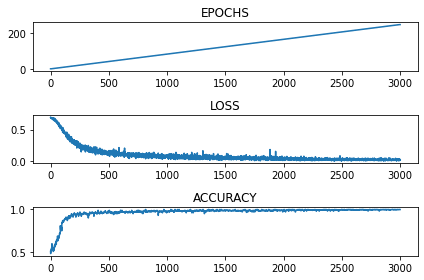


Test accuracy: 0.9540635943412781
sentiment for exciting word:  tensor([[1.]], grad_fn=<SigmoidBackward>)
sentiment for hatred word:  tensor([[4.9390e-18]], grad_fn=<SigmoidBackward>)


In [ ]:
import torch
import random
import h5py
from tqdm.notebook import tqdm
import os

! mkdir Dataset
! wget "http://conceptnet.s3.amazonaws.com/precomputed-data/2016/numberbatch/17.06/mini.h5" -P "./Dataset"
! wget "https://github.com/duke-mlss/Duke-MLSS-2018/blob/master/movie-simple.txt" -P "./Dataset"

with h5py.File("./Dataset/mini.h5",'r') as f:
  all_word = [word.decode('utf-8') for word in f['mat']['axis1'][:]]
  all_embeddings = f['mat']['block0_values'][:]

index = random.randrange(len(all_word))
#print("any random word ",all_word[index])
#print(all_embeddings[index])

english_words = [word[6:] for word in all_word if word.startswith('/c/en/')]
#print(english_words)

english_indices = [i for i,word in enumerate(all_word) if word.startswith('/c/en/')]
english_embeddings = all_embeddings[english_indices]

indexx = random.randrange(len(english_words))
#print(english_words[indexx],english_embeddings[indexx])

import numpy as np

norms = np.linalg.norm(english_embeddings,axis = 1)
norms_embeddings = english_embeddings.astype('float32')/norms.astype('float32').reshape([-1,1])

indx = random.randrange(len(english_words)//20)
#print(f"english word:{english_words[indx]} \n \
#embeddings:{english_embeddings[indx]}\n \
#norms_embeddings: {norms_embeddings[indx]}")

eng_dict = {word:i for i,word in enumerate(english_words)}
eng_norms = {word:norms_embeddings[eng_dict[word]] for word in english_words}

def similar_score(w1,w2):
  score =  np.dot(norms_embeddings[eng_dict[w1],:],norms_embeddings[eng_dict[w2],:])
  return score

def closest_vector(v,n):
  all_scores = np.dot(norms_embeddings,v)
  best_words = list(map(lambda i:english_words[i],reversed(np.argsort(all_scores))))
  return best_words[:n]

def most_similar(w,n):
  return closest_vector(norms_embeddings[eng_dict[w],:],n)

def solve_analogy(a1,b1,a2):
  b2 = norms_embeddings[eng_dict[a2],:]+norms_embeddings[eng_dict[b1],:]-norms_embeddings[eng_dict[a1],:]
  return closest_vector(b2,1)

import string
remove_punct=str.maketrans('','',string.punctuation)

def convert_line_to_example(line):
  y = int(line[0])
  #word embeddings and their mean
  #label

  words = line[2:].translate(remove_punct).lower().split()
  embedding = [norms_embeddings[eng_dict[w]] for w in words if w in eng_dict]

  x = np.mean(np.vstack(embedding),axis=0)
  return x,y

xs = []
ys = []

with open('./Dataset/movie-simple.txt') as f:
  for l in f.readlines():
    x,y = convert_line_to_example(l)
    xs.append(x)
    ys.append(y)

xs = np.vstack(xs)
ys = np.vstack(ys)

#print(xs,ys)

#print("First 20 labels before shuffling: {0}".format(ys[:20, 0]))

num_examples = xs.shape[0]
shuffle_idx = np.random.permutation(num_examples)
xs = xs[shuffle_idx, :]
ys = ys[shuffle_idx, :]

#print("First 20 labels after shuffling: {0}".format(ys[:20, 0]))

import torch

num_train = 4*num_examples // 5

x_train = torch.tensor(xs[:num_train])
y_train = torch.tensor(ys[:num_train], dtype=torch.float32)

x_test = torch.tensor(xs[num_train:])
y_test = torch.tensor(ys[num_train:], dtype=torch.float32)

reviews_train = torch.utils.data.TensorDataset(x_train,y_train)
reviews_test = torch.utils.data.TensorDataset(x_test,y_test)

trainbatches = torch.utils.data.DataLoader(reviews_train,batch_size=100,shuffle=True)
testbatches = torch.utils.data.DataLoader(reviews_test,batch_size=100,shuffle=False)

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim

class SWEM_sentiment(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(300,64)
    self.fc2 = nn.Linear(64,1)

  def forward(self,x):
    x = self.fc1(x)
    x = F.relu(x)
    y = self.fc2(x)
    return y

movie_sentiment = SWEM_sentiment()

Loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(movie_sentiment.parameters(),lr=0.001)

EPOCHS = 250
BATCHES = len(trainbatches)

results = [[],[],[]]

for e in tqdm(range(EPOCHS)):
  correct = 0
  num_example = 0
  for avg_embeds,labels in trainbatches:
    optimizer.zero_grad()

    y = movie_sentiment(avg_embeds)
    #print(avg_embeds.shape,y)
    loss = Loss(y,labels)

    loss.backward()
    optimizer.step()

    #checking alongside
    predict = torch.round(torch.sigmoid(y))
    correct += torch.sum((predict==labels).float())
    num_example+=len(avg_embeds)

    results[0].append(e)
    results[1].append(loss)
    results[2].append(correct/num_example)

    #print(predict==labels)
"""
  if e % 25 == 0:
        acc = correct/num_example
        print("Epoch: {0} \t Train Loss: {1} \t Train Acc: {2}".format(e, loss, acc))
"""
fig, axes = plt.subplots(3)

axes[0].plot(results[0])
axes[0].set_title('EPOCHS')

axes[1].plot(results[1])
axes[1].set_title('LOSS')

axes[2].plot(results[2])
axes[2].set_title('ACCURACY')

fig.tight_layout()
plt.show()

correct = 0
num_test = 0

result = []

with torch.no_grad():
  # Iterate through test set minibatchs 
  for inputs, labels in tqdm(testbatches):
    # Forward pass
    y = movie_sentiment(inputs)
    
    predictions = torch.round(torch.sigmoid(y))
    correct += torch.sum((predictions == labels).float())
    num_test += len(inputs)

    acc = correct/num_test
    result.append(acc)
    #print("Epoch: {0} \t Train Loss: {1} \t Train Acc: {2}".format(1, loss, acc))

print('Test accuracy: {}'.format(correct/num_test))

test_words=['exciting','hatred']

for w in test_words:
  embeds = torch.Tensor(norms_embeddings[eng_dict[w]]).view(1,300)
  print(f"sentiment for {w} word: ",torch.sigmoid(movie_sentiment(embeds)))



In [ ]:
output = convert_line_to_example("1   She's my best student last year who I read Harry Potter with, and I LOVE harry potter!")
#print(output)
em, lb = output
#print(em,lb)

with torch.no_grad():
  em = torch.Tensor(em)
  y = movie_sentiment(em.view(1,1,1,300))
  #val = torch.tanh(torch.argmax(y,dim=1))
  print(y)

tensor([[[[9.0535]]]])


In [ ]:
with torch.no_grad():
  z = 100/(1 + np.exp(-y))
  if z[0][0][0] > 50:
    print("positive review")
  else :
    print("neagetive review")
  print("Percentage: {} %".format(float(z[0][0][0]))) 

positive review
Percentage: 99.9883041381836 %
